In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#El tentativa 

In [ ]:
#Importes

#Funções próprias
import sys
sys.path.append('/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/')
import utils
from utils import *

#Visualização de dados
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

#Pré-processamento
!pip install emot
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

#Manipulação de dados
import json
from sklearn.model_selection import train_test_split
import numpy as np

#Redes neurais
import torch
from torch import nn

import time
from IPython.display import clear_output
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
np.random.seed(666)
torch.manual_seed(666)

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/Dataset_depression_REVISADO.csv', index_col=0)
dataset.head()

,usuario,texto,depressao,texto_traduzido
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\n\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https://t.co/I8SzMHuYV4
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face


In [ ]:
dataset['texto_traduzido'].dtype

dtype('O')

In [ ]:
dataset['texto_traduzido'] = dataset['texto_traduzido'].astype(str)

#Pré-processamento

##"Tradução" de emojis

In [ ]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").split()))
        text = text.replace(":"," ")
    return text

In [ ]:
dataset['documento_processado'] = dataset['texto_traduzido'].apply(lambda x: convert_emojis(x))

In [ ]:
dataset.head()

,usuario,texto,depressao,texto_traduzido,documento_processado
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\n\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https://t.co/I8SzMHuYV4,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https //t.co/I8SzMHuYV4
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life,Shaken by the whole situation of my life
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,then I am always happy for the achievements of my friends you know .... seriously
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,taking a deep breath not to punch anyone in the face


##Limpeza de texto

In [ ]:
dataset['documento_processado'] = dataset['documento_processado'].apply(lambda x: clean_text(x))

In [ ]:
dataset.head()

,usuario,texto,depressao,texto_traduzido,documento_processado
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\n\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https://t.co/I8SzMHuYV4,"[broken, without, mother, want, cancel, schizophren, gave, internet, today, http, co, i8szmhuyv4]"
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo,"[noth, absolut, free, crowd, comment, sport, profil, casagrand, photo]"
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life,"[shaken, whole, situat, life]"
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,"[alway, happi, achiev, friend, know, serious]"
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,"[take, deep, breath, punch, anyon, face]"


##Codificando o texto para o nosso modelo

In [ ]:
with open('/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/vocab.json', 'r') as fp:
    word2idx = json.load(fp)

In [ ]:
idx2word = list(word2idx.keys()) # apenas transforma as chaves (palavras ordenadas) do dicionário word2idx em uma lista

# testando a conversão "index to word":
print(f'word for index 0:    {idx2word[0]}')
print(f'word for index 100": {idx2word[100]}')

word for index 0:    <OOV>
word for index 100": addl


In [ ]:
max_len = 30         # comprimento máximo da mensagem (em número de palavras)
encoded_docs = []    # inicializa a lista de documentos codificados

for doc in dataset['documento_processado']: # para cada texto
  encoded_d = [word2idx.get(t,word2idx['<OOV>']) for t in doc]    # codifica o documento usando o dicionário word2idx
  encoded_d += [word2idx['<PAD>']]*max(0, max_len-len(encoded_d))    # adiciona o padding, se necessário
  
  encoded_docs.append(encoded_d[:max_len])                           # trunca o documento e salva na lista de documentos codificados

len(encoded_docs)  

1411

In [ ]:
dataset['documento_processado'] = encoded_docs
dataset.head()

,usuario,texto,depressao,texto_traduzido,documento_processado
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\n\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https://t.co/I8SzMHuYV4,"[1107, 9966, 5784, 9757, 1254, 0, 3589, 4550, 9048, 4223, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo,"[6095, 31, 3460, 2007, 1696, 8350, 6927, 0, 6610, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life,"[7851, 9892, 8023, 5128, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,"[269, 3927, 73, 3484, 4922, 7819, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,"[8766, 2190, 1074, 7012, 380, 3090, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


#Chamando o modelo de previsão de emoções

In [ ]:
import myclass
from myclass import *

In [ ]:
model = torch.load('/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/Models/newmodel.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/Models/newmodel_dict'))
model.eval()

mood_classifier(
  (embedding): Sequential(
    (0): Embedding(10154, 50)
    (1): Torch_Mean_Layer()
  )
  (ann): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
  (soft): Sequential(
    (0): LogSoftmax(dim=1)
  )
)

In [ ]:
e = next(model.embedding[0].parameters())
e.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6488, -1.2422, -2.6443,  ..., -1.4651,  1.4021, -0.5817],
        ...,
        [ 0.2771,  0.7892,  1.4962,  ..., -0.9299,  1.3295, -0.4340],
        [ 0.3833,  0.5704, -0.4672,  ..., -1.8212, -1.9639,  0.2115],
        [ 0.4678, -0.7618,  0.9770,  ...,  0.8908,  1.4307, -2.5102]])

#Adcionando a *feature* do modelo de previsão de emoções

In [ ]:
X_test = np.vstack(dataset['documento_processado'])
X_test = torch.LongTensor(X_test)

In [ ]:
preds = model.forward(X_test)

In [ ]:
dataset

,usuario,texto,depressao,texto_traduzido,documento_processado
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\n\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https://t.co/I8SzMHuYV4,"[1107, 9966, 5784, 9757, 1254, 0, 3589, 4550, 9048, 4223, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo,"[6095, 31, 3460, 2007, 1696, 8350, 6927, 0, 6610, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life,"[7851, 9892, 8023, 5128, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,"[269, 3927, 73, 3484, 4922, 7819, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,"[8766, 2190, 1074, 7012, 380, 3090, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...,...
1406,brandnewgirly,kkkkk reinstalar tudo de novo,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1407,EuPedroliveira,Finalmente... https://t.co/K5JATUfl1L,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1408,brandnewgirly,nessa economia? no meio de uma pandemia??? https://t.co/um1fwYfqvz,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1409,cyberfuckbaby,o meu problema eh que eu fico estressada e me estresso com todo mundo ao meu redor e depois fico estressada sozinha e estressada por estar estressada https://t.co/tyNlFj0aeT,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


## Criando colunas com os preds

In [ ]:
dataset["previsoes"] = [torch.exp(pred).detach().numpy() for pred in preds]
dataset.head()

,usuario,texto,depressao,texto_traduzido,documento_processado,previsoes
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\n\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https://t.co/I8SzMHuYV4,"[1107, 9966, 5784, 9757, 1254, 0, 3589, 4550, 9048, 4223, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.00074784545, 0.94875383, 9.555406e-07, 1.9359092e-07, 0.0054791006, 0.04501809]"
1,rnnpgn,Não tem nada absolutamente mais SEM GRAÇA do que essa galera comentando em perfis esportivos com a foto do Casagrande,0,There is nothing absolutely NO MORE FREE than this crowd commenting on sports profiles with Casagrande's photo,"[6095, 31, 3460, 2007, 1696, 8350, 6927, 0, 6610, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2.1448923e-09, 7.613771e-19, 0.9994955, 1.1911975e-19, 0.00050445716, 6.7641123e-18]"
2,KMoraez,Abalada com toda a situação da minha vida,0,Shaken by the whole situation of my life,"[7851, 9892, 8023, 5128, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[7.0239166e-09, 0.99999857, 5.079531e-12, 2.6927783e-12, 7.3848234e-09, 1.477715e-06]"
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,"[269, 3927, 73, 3484, 4922, 7819, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.72761333, 0.26944298, 9.606568e-08, 7.611875e-10, 1.6464584e-06, 0.002942025]"
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,"[8766, 2190, 1074, 7012, 380, 3090, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.04012903, 0.00053922134, 0.95592105, 1.1142848e-05, 0.0033658873, 3.3569224e-05]"


In [ ]:
dataset.query("depressao==1")

,usuario,texto,depressao,texto_traduzido,documento_processado,previsoes
0,lIlIIIlllllIII,arrombada sem mae querendo cancelar um esquizofrênico\n\ndeu de internet por hoje https://t.co/I8SzMHuYV4,1,broken into without a mother wanting to cancel a schizophrenic\n\ngave internet for today https://t.co/I8SzMHuYV4,"[1107, 9966, 5784, 9757, 1254, 0, 3589, 4550, 9048, 4223, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.00074784545, 0.94875383, 9.555406e-07, 1.9359092e-07, 0.0054791006, 0.04501809]"
3,rammassss,aí sempre fico feliz pelas conquistas dos meus amigos sabe.... sério,1,then I am always happy for the achievements of my friends you know .... seriously,"[269, 3927, 73, 3484, 4922, 7819, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.72761333, 0.26944298, 9.606568e-08, 7.611875e-10, 1.6464584e-06, 0.002942025]"
4,fuckjxxnny_oh,respirando fundo pra nao socar a cara de ngm,1,taking a deep breath not to punch anyone in the face,"[8766, 2190, 1074, 7012, 380, 3090, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.04012903, 0.00053922134, 0.95592105, 1.1142848e-05, 0.0033658873, 3.3569224e-05]"
8,tarjapretaporra,Amanhã faço exame médico demissional.\nImagina como tá a cabeça.,1,Tomorrow I have a dismissal medical exam.\nImagine how your head is doing.,"[9070, 2449, 5513, 3004, 4322, 3980, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0011667309, 0.90109473, 1.1840637e-05, 0.003826406, 4.1380456e-05, 0.09385894]"
9,bs_arth,hamsuke eu te odeio\n\nPERSONAGEM INSUPORTAVEL,1,hamsuke i hate you\n\nINSUPERABLE CHARACTER,"[0, 3963, 0, 1422, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.7962552, 0.00080459984, 0.00022370701, 3.6735488e-09, 0.20271556, 8.682401e-07]"
...,...,...,...,...,...,...
1406,brandnewgirly,kkkkk reinstalar tudo de novo,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.25137547, 0.26347435, 0.14882806, 0.006352847, 0.2708089, 0.059160437]"
1407,EuPedroliveira,Finalmente... https://t.co/K5JATUfl1L,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.25137547, 0.26347435, 0.14882806, 0.006352847, 0.2708089, 0.059160437]"
1408,brandnewgirly,nessa economia? no meio de uma pandemia??? https://t.co/um1fwYfqvz,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.25137547, 0.26347435, 0.14882806, 0.006352847, 0.2708089, 0.059160437]"
1409,cyberfuckbaby,o meu problema eh que eu fico estressada e me estresso com todo mundo ao meu redor e depois fico estressada sozinha e estressada por estar estressada https://t.co/tyNlFj0aeT,1,nan,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.25137547, 0.26347435, 0.14882806, 0.006352847, 0.2708089, 0.059160437]"


# Tirando a média

In [ ]:
df = dataset.copy()
dataset.set_index('usuario', inplace=True)

In [ ]:
#Funções necessárias

def get_matriz_user(distributions):
  """
  Pega as distruibuições do usuário (O resultado o modelo de emoções de todos os tweets) e cria uma matriz
  """
  matriz = np.vstack(distributions)

  return matriz


def get_media_user(matriz):
  """
  Pega a matriz dos vetores resultantes do modelo de previsão de emoções e faz a média
  """
  media = matriz.mean(axis=0).reshape(1,-1)

  return media

In [ ]:
unique_users1 = df.query('depressao == 1')['usuario'].unique()
unique_users0 = df.query('depressao == 0')['usuario'].unique()

df_final = pd.DataFrame(columns=['user','emotions_avg_dist', 'depression'])

#EL GAMBIARRA (arrumar depois)
  
for user in unique_users1:
  df_user = dataset.loc[user] #Pegando o usuário e seus tweets
  distributions_of_user = df_user['previsoes'] #Pegando as distribuições

  matriz_de_distribuicao = get_matriz_user(distributions_of_user)
  media_usuario = get_media_user(matriz_de_distribuicao)
  media_usuario = media_usuario/media_usuario.sum()

  df_of_new_row = pd.DataFrame(data=[[user, media_usuario, 1]], columns=['user','emotions_avg_dist','depression']) #Criando uma nova linha
  df_final = df_final.append(df_of_new_row,ignore_index=True) #Adcionando a nova linha no dataframe

for user in unique_users0:
  df_user = dataset.loc[user] #Pegando o usuário e seus tweets
  distributions_of_user = df_user['previsoes'] #Pegando as distribuições

  matriz_de_distribuicao = get_matriz_user(distributions_of_user)
  media_usuario = get_media_user(matriz_de_distribuicao)
  media_usuario = media_usuario/media_usuario.sum()

  df_of_new_row = pd.DataFrame(data=[[user, media_usuario, 0]], columns=['user','emotions_avg_dist','depression']) #Criando uma nova linha
  df_final = df_final.append(df_of_new_row,ignore_index=True) #Adcionando a nova linha no dataframe

df_final

,user,emotions_avg_dist,depression
0,lIlIIIlllllIII,"[[0.46291512, 0.15922095, 0.19412252, 0.0022435617, 0.16788732, 0.013610494]]",1
1,rammassss,"[[0.21733761, 0.17177665, 0.28496626, 0.005725668, 0.20115803, 0.11903576]]",1
2,fuckjxxnny_oh,"[[0.270733, 8.24716e-05, 0.39498517, 0.09555822, 0.23389252, 0.004748623]]",1
3,tarjapretaporra,"[[0.041298855, 0.1527894, 0.26767418, 0.0012678651, 0.39912, 0.13784966]]",1
4,bs_arth,"[[0.31950018, 0.09887898, 0.28920445, 0.106392555, 0.14014764, 0.045876205]]",1
...,...,...,...
302,idfchae,"[[2.7218191e-05, 1.4302323e-07, 0.27173588, 0.35294953, 0.36881867, 0.006468624]]",0
303,sofiihLsS,"[[0.0021630104, 0.0011691652, 0.6569621, 0.006595, 0.33208004, 0.0010307025]]",0
304,mriasant,"[[0.2, 1.4356445e-06, 0.59999263, 4.2141863e-07, 0.2000055, 3.986278e-10]]",0
305,jacobsafes,"[[0.2513755, 0.26347438, 0.14882807, 0.0063528474, 0.27080894, 0.05916044]]",0


In [ ]:
df_final.iloc[10]['emotions_avg_dist'].sum()

1.0

In [ ]:
df_final.query('depression==1')

,user,emotions_avg_dist,depression
0,lIlIIIlllllIII,"[[0.46291512, 0.15922095, 0.19412252, 0.0022435617, 0.16788732, 0.013610494]]",1
1,rammassss,"[[0.21733761, 0.17177665, 0.28496626, 0.005725668, 0.20115803, 0.11903576]]",1
2,fuckjxxnny_oh,"[[0.270733, 8.24716e-05, 0.39498517, 0.09555822, 0.23389252, 0.004748623]]",1
3,tarjapretaporra,"[[0.041298855, 0.1527894, 0.26767418, 0.0012678651, 0.39912, 0.13784966]]",1
4,bs_arth,"[[0.31950018, 0.09887898, 0.28920445, 0.106392555, 0.14014764, 0.045876205]]",1
...,...,...,...
164,taah_rd,"[[0.2513755, 0.26347438, 0.14882806, 0.0063528474, 0.27080894, 0.05916044]]",1
165,laribasg,"[[0.2513755, 0.26347438, 0.14882807, 0.0063528474, 0.27080894, 0.05916044]]",1
166,brandnewgirly,"[[0.2513755, 0.26347438, 0.14882806, 0.006352847, 0.27080894, 0.05916044]]",1
167,aingridviaja,"[[0.25137544, 0.26347435, 0.14882803, 0.0063528456, 0.27080888, 0.059160426]]",1


In [ ]:
df_final = df_final.sample(frac=1).reset_index(drop=True)
df_final

,user,emotions_avg_dist,depression
0,I_Lunax,"[[6.51328e-09, 6.099063e-11, 0.16549878, 0.59537786, 0.23912315, 2.01189e-07]]",0
1,ughfruit,"[[0.34104776, 0.14822173, 0.23406762, 0.0012114466, 0.2524722, 0.022979258]]",0
2,onlyparrillax,"[[0.14924419, 0.1221816, 0.35336807, 0.14405644, 0.12503414, 0.10611556]]",1
3,habitlaurj,"[[0.06527759, 0.30044103, 0.3991806, 0.0009858876, 0.20008437, 0.034030538]]",1
4,_patyjesuss,"[[0.021365114, 0.0014657622, 0.30203113, 0.0070825364, 0.66713, 0.00092549645]]",0
...,...,...,...
302,aprilrudgate,"[[9.112487e-06, 0.32879505, 0.6709514, 2.1033325e-06, 0.00024206797, 2.849229e-07]]",1
303,Tita_ffc,"[[5.153901e-07, 1.0785996e-06, 0.6667169, 0.12632318, 4.5346198e-08, 0.20695835]]",0
304,Isadoraasilvaa,"[[1.1073225e-05, 0.278951, 0.3335641, 3.1723968e-07, 0.38746697, 6.6398447e-06]]",1
305,ExAnaPaula,"[[0.00044428714, 0.15687403, 0.32374468, 0.14439389, 0.34603873, 0.02850445]]",1


##Train Test Split

In [ ]:
X = df_final.drop(['depression'], axis=1)
y = df_final['depression']

In [ ]:
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=666, shuffle=True)

In [ ]:
X_train_df.shape, y_train.shape, X_test_df.shape, y_test.shape

((230, 2), (230,), (77, 2), (77,))

In [ ]:
y_train.value_counts()

1    127
0    103
Name: depression, dtype: int64

In [ ]:
y_train.value_counts(normalize=True) * 100

1    55.217391
0    44.782609
Name: depression, dtype: float64

In [ ]:
y_test.value_counts(normalize=True) * 100

1    54.545455
0    45.454545
Name: depression, dtype: float64

In [ ]:
y_test.value_counts()

1    42
0    35
Name: depression, dtype: int64

In [ ]:
type(y_test.to_numpy())

numpy.ndarray

## Criando ***El Modelo***

In [ ]:
class depression_detection(nn.Module):
  '''Modelo classificador de emoções
  '''
  # ----------------------------------------------#
  # Método construtor
  def __init__(self, n_in, num_layers, num_units): 

    super().__init__()  
    ann_seq       = [] # 

    #--------------------------------------------------------------------------#
    # ANN: Rede Neural Artifical Tradicional, com regressão logística na saída
    for i in range(1, num_layers):
      ann_seq.append(nn.Linear(in_features=num_units[i-1], out_features=num_units[i]))
      ann_seq.append(nn.ReLU(inplace=True))
    ann_seq.append(nn.Linear(in_features=num_units[-1], out_features=1))
    ann_seq.append(nn.Sigmoid())
    
    #--------------------------------------------------------------------------#
    # "merge" de todas as camamadas em uma layer sequencial 
    # (uma sequência para cada etapa)
    self.ann= nn.Sequential(*ann_seq)           # etapa ANN
    #--------------------------------------------------------------------------#

  def forward(self, x): 
    '''
    Processamento realizado ao chamar y=modelo(x)
    '''
    x = self.ann(x)        # passa o embedding médio pelas camadas da ANN
    return x  

In [ ]:
def train_loop(model, data_train, data_test, max_epochs = 1000, print_iters = 5):
  X_train, Y_train = data_train
  X_test, Y_test = data_test
  losses = []
  accs = []
  for i in range(max_epochs): # para cada época

      #-----------------------------------#
      # INÍCIO DO WORKFLOW DO TREINAMENTO #
      # 
      # Add mistura
      Y_pred = model.forward(X_train)         # apresente os dados de entrada para o modelo, e obtenha a previsão    
      loss = criterion(Y_pred, Y_train)                      # calcule a perda (o custo, o erro)
      optimizer.zero_grad()                   # inicialize os gradientes
      loss.backward()                         # backpropagation sobre a perda atual (cálculo dos novos gradientes) 
      optimizer.step()                        # atualização dos parâmetros da rede utilizando a regra do otimizador escolhido

      
      # FIM DO WORKFLOW DO TREINAMENTO    #
      #-----------------------------------#

      # ------ Bloco Opcional ------ #
      # Salvando métricas
      losses.append(loss)                     # salvando a perda atual
      acc = calc_accuracy(Y_pred, Y_train)     # calcula a taxa de acerto atual
      accs.append(acc)
      
      # Imprimindo resultados parciais
      if i % print_iters ==0: # a cada 10 iterações
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}') 
      #-----------------------------------#

  #----------------------------------------------------------------------------# 
  print('\n# Finished training!')
  print(f'# --> epoch: {i}  \n# --> initial loss: {losses[0]:10.8f} ,  \n# --> accuracy: {acc:2.8f} , \n# --> final loss: {losses[-1]:10.8f}')
  
  # retornando resultados
  return model, losses, accs

# Redefinindo cálculo da taxa de acerto 
def calc_accuracy(y_pred, y_true):
  ''' Helper function para calcular a taxa de acerto deste exemplo.
  '''
  num_hits  = torch.sum(torch.round(y_pred)==y_true).numpy()
  num_total =  float(y_true.numel())
  acc=  num_hits/num_total
  return acc

In [ ]:

X_train = np.vstack(X_train_df['emotions_avg_dist'])
Y_train = np.vstack(y_train).reshape(-1,1)
X_train.shape, X_train[0].shape, Y_train.shape, Y_train[0].shape


((230, 6), (6,), (230, 1), (1,))

In [ ]:
X_test = np.vstack(X_test_df['emotions_avg_dist'])
Y_test = np.vstack(y_test).reshape(-1,1)
X_test.shape, X_test[0].shape, Y_test.shape, Y_test[0].shape

((77, 6), (6,), (77, 1), (1,))

In [ ]:
data_train = (torch.FloatTensor(X_train), torch.FloatTensor(Y_train))

data_test = (torch.FloatTensor(X_test), torch.FloatTensor(Y_test))

## Melhorando com hiperparâmetros

In [ ]:
# Código baseado no github do professor Bruno Fontana. 
from sklearn.model_selection import ParameterGrid

Ajustar_Hiperparametros = True     

param_dict = {}
param_dict['learning_rate'] = np.linspace(0.01, 0.1, 10) # [0.1, 0.01, 0.001] # exemplos de buscas: np.linspace(1e-2,5e-2,5) ou np.logspace(-3,-1,20)
param_dict['layers'] = [
                        (2, [6, 40]),
                        (2, [6, 48]),
                        (2, [6, 52]),
                        (3, [6, 48, 8]),
                        (3, [6, 48, 16]),
                        (3, [6, 48, 32]),
                        (3, [6, 48, 48]),
                        (3, [6, 48, 64])]
                        # (4, [6, 100, 50, 25]), 
                        # (5, [6, 200, 100, 50, 25]),
                        # (6, [6, 400, 200, 100, 50, 25])]              # exemplos de buscas: np.arange(start=1,stop=4)
# param_dict['num_units'] = [[6, 100, 50, 25], [6, 200, 100, 50, 25]]         # exemplos de buscas: np.arange(10,15)

param_dict['max_epochs']= [3000]     # maximum number of iterations running over the training set

Num_HyperParams_to_test = len(ParameterGrid(param_dict))

In [ ]:
criterion = nn.BCELoss() # binary cross-entropy

if Ajustar_Hiperparametros:
  acc_test_list = []
  max_acc_test = -np.inf
  best_params = None
  idx_best = None
  for idx, params in enumerate(ParameterGrid(param_dict)):
    learning_rate = params['learning_rate']      # learning rate for parameter updates
    L, num_units = params['layers']                              # depth of ANN (number of hidden layers)
    #num_units = params['num_units']                    # 2**Nu_exp = Number of units per HL
    max_epochs = params['max_epochs']            # num. of iterations over the full dataset

    print(f'Testing parameters {idx}/{Num_HyperParams_to_test}: {params}')

    torch.manual_seed(666)
    model = depression_detection(n_in=6, num_layers=L, num_units=num_units)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
    model, losses, accs = train_loop(model, data_train, data_test, max_epochs=max_epochs, print_iters=1000)

    # print(f'Model {model}',f'Criterion: {criterion}',f'Optimizer: {optimizer}',sep=2*'\n')

    X_test, Y_test = data_test
    with torch.no_grad():
      Y_pred = model(X_test)
      num_hits  = torch.sum(torch.round(Y_pred)==Y_test).numpy()
      num_total =  float(Y_test.numel())
      acc_test = num_hits/num_total
      # print(f'TEST SCORE: Torch loss {acc_test.item():10.6f}  (ANN)')

    if acc_test > max_acc_test:
      max_acc_test = acc_test
      best_params = params
      losses_best, acc_best = (losses, accs)
      idx_best = idx
      best_model = model

    acc_test_list.append(acc_test)


    # clear_output(wait=True)
  print("best_params", best_params, "acc_test_list", acc_test_list, "idx_best", idx_best, "acc_best", acc_test_list[idx_best], sep="\n")

else:
  model = depression_detection(n_in=6, num_layers=2, num_units=[6,48])
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) 
  best_model, losses_best, acc_best = train_loop(model, data_train, data_test,max_epochs=2000, print_iters=1)

Testing parameters 0/80: {'layers': (2, [6, 40]), 'learning_rate': 0.01, 'max_epochs': 3000}
epoch:  0  loss: 0.70156884
epoch: 1000  loss: 0.38622493
epoch: 2000  loss: 0.34285405

# Finished training!
# --> epoch: 2999  
# --> initial loss: 0.70156884 ,  
# --> accuracy: 0.87826087 , 
# --> final loss: 0.30933931
Testing parameters 1/80: {'layers': (2, [6, 40]), 'learning_rate': 0.020000000000000004, 'max_epochs': 3000}
epoch:  0  loss: 0.70156884
epoch: 1000  loss: 0.43858376
epoch: 2000  loss: 0.37706429

# Finished training!
# --> epoch: 2999  
# --> initial loss: 0.70156884 ,  
# --> accuracy: 0.81304348 , 
# --> final loss: 0.35151574
Testing parameters 2/80: {'layers': (2, [6, 40]), 'learning_rate': 0.030000000000000006, 'max_epochs': 3000}
epoch:  0  loss: 0.70156884
epoch: 1000  loss: 0.31776780
epoch: 2000  loss: 0.28076723

# Finished training!
# --> epoch: 2999  
# --> initial loss: 0.70156884 ,  
# --> accuracy: 0.87826087 , 
# --> final loss: 0.24936949
Testing parameter

In [ ]:
print(best_model)

depression_detection(
  (ann): Sequential(
    (0): Linear(in_features=6, out_features=52, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=52, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
# Model, losses, accs = train_loop(model, data_train, data_test, max_epochs=1000, print_iters=1) # note que o modelo é sobrescrito pela saída treinada

In [ ]:
X_train = torch.FloatTensor(X_train)

In [ ]:
Y_pred = best_model(X_train)

#Visualizando resultados

##Gráfico de Loss e Accuracy

In [ ]:
def plot_loss_and_accuracy(losses, accs):

  fig, ax_tuple = plt.subplots(1, 2, figsize=(16,6))
  fig.suptitle('Loss and accuracy')

  for i, (y_label, y_values) in enumerate(zip(['BCE loss','Accuracy'],[losses, accs])):
    ax_tuple[i].plot(range(len(y_values)),  y_values, label='train')
    ax_tuple[i].set_xlabel('epochs')
    ax_tuple[i].set_ylabel(y_label)
    ax_tuple[i].legend()
  
  ax_tuple[1].set_ylim([0,1])

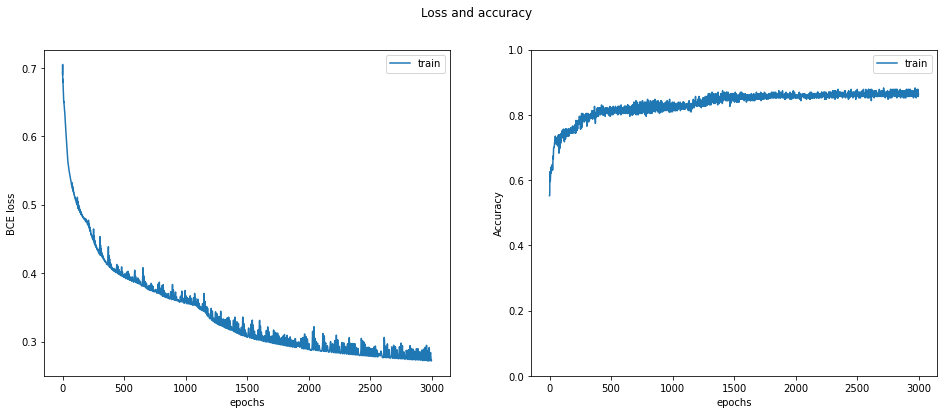

In [ ]:
plot_loss_and_accuracy(losses_best, acc_best)

##Confusion Matrix

In [ ]:
X_test = np.vstack(X_test)
Y_test = np.vstack(y_test).reshape(-1,1)
X_test = torch.FloatTensor(X_test)
Y_test =  torch.FloatTensor(Y_test)
X_test.shape, Y_test.shape

(torch.Size([77, 6]), torch.Size([77, 1]))

In [ ]:
Y_pred = best_model(X_test)
#Y_pred[:10]

In [ ]:
Y_test.dtype

torch.float32

In [ ]:
X, Y = data_test
with torch.no_grad():
    Y2 = best_model(X)
    num_hits  = torch.sum(torch.round(Y2)==Y).numpy()
    num_total =  float(Y.numel())
    acc_test = num_hits/num_total

acc_test

0.6233766233766234

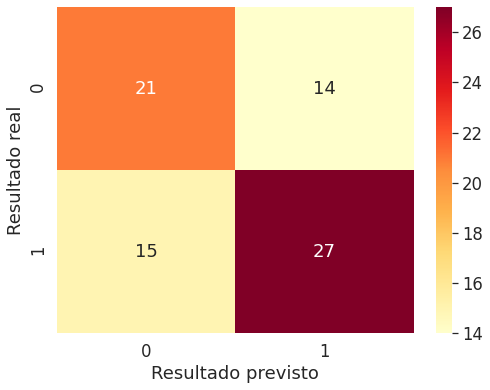

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1.5)

# confusion matrix daora TEM Q MELHORAR
def plot_conf_mat(y_test, y_preds, norm=None):
   fig, ax = plt.subplots(figsize=(8, 6))
   ax = sns.heatmap(confusion_matrix(y_test, y_preds, normalize=norm),
                   annot=True,
                    fmt="d",
                    cmap="YlOrRd")
   plt.xlabel("Resultado previsto")
   plt.ylabel("Resultado real")


plot_conf_mat(Y_test.detach().numpy(), Y_pred.detach().numpy().round())

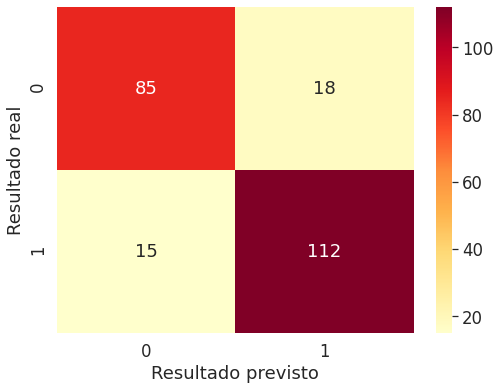

In [ ]:
Y_predtrain = best_model(X_train)
plot_conf_mat(Y_train, Y_predtrain.detach().numpy().round())

## F1 Score

In [ ]:
from sklearn.metrics import f1_score

f1_score(Y_test.detach().numpy(), Y_pred.detach().numpy().round())

0.6506024096385543

## Recall Score

In [ ]:
from sklearn.metrics import recall_score

recall_score(Y_test.detach().numpy(), Y_pred.detach().numpy().round())

0.6428571428571429

##Precision

In [ ]:
from sklearn.metrics import precision_score

precision_score(Y_test.detach().numpy(), Y_pred.detach().numpy().round())

0.6585365853658537

## ROC Curve

In [ ]:
# função pra plotar a ROC curve

def plot_roc_curve(fpr, tpr):
    
    plt.plot(fpr, tpr, color="orange", label="ROC")  
    plt.plot([0,1],[0,1], color="darkblue", linestyle="--", label="Guessing")
    
    plt.xlabel("Taxa de falsos positivos  (fpr)")
    plt.ylabel("Taxa verdadeira positiva (tpr)")
    plt.title("Receiver Operating Characteristics (ROC) curve")
    plt.legend()
    plt.show()

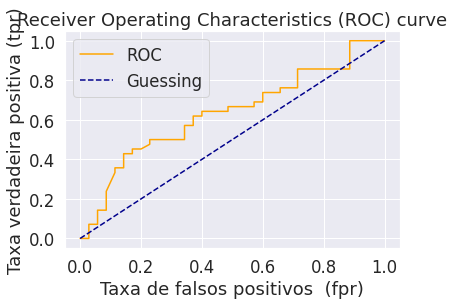

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test.detach().numpy(), Y_pred.detach().numpy())
plot_roc_curve(fpr, tpr)

## ROC/AUC Score

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test.detach().numpy(), Y_pred.detach().numpy())

0.6329931972789116

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# compare the truth labels to the predicted labels
print(classification_report(Y_test.detach().numpy(), Y_pred.detach().numpy().round()))

              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59        35
         1.0       0.66      0.64      0.65        42

    accuracy                           0.62        77
   macro avg       0.62      0.62      0.62        77
weighted avg       0.62      0.62      0.62        77



##Falsos Negativos

In [ ]:
moods = {"Anger": 0, "Fear" : 1, "Joy" : 2, "Love" : 3, "Sadness" : 4, "Suprise" : 5}
sdoom = {0 : "Anger", 1: "Fear", 2: "Joy", 3: "Love", 4: "Sadness", 5: "Suprise"}
emotions = list(moods.keys())

In [ ]:
Ytrue1 = Y_test.detach().numpy() == 1
Ypred0 = Y_pred.detach().numpy().round() == 0

In [ ]:
X_test_df[Ytrue1.reshape(-1) & Ypred0.reshape(-1)]  #Onde era verdadeiro e foi previsto falso  (FALSO NEGATIVO)

,user,emotions_avg_dist
181,hadassa_rebecah,"[[0.5892867, 0.16615497, 0.0019476643, 1.2866371e-07, 0.20165616, 0.040954396]]"
215,taveirao,"[[1.17025875e-05, 0.33304593, 0.33332512, 1.0709086e-05, 1.8564011e-06, 0.3336047]]"
136,BielBravo1,"[[0.20001686, 0.19964576, 0.39533705, 8.550821e-09, 0.20467141, 0.00032893853]]"
86,hurricanequak,"[[0.015836533, 0.0008915385, 0.76328003, 0.01908173, 0.2008048, 0.000105393425]]"
202,GermanaAngelica,"[[0.49999997, 9.882278e-09, 0.49999976, 2.5296544e-07, 5.2463996e-08, 5.9253082e-09]]"
147,je_ecobaby,"[[9.767108e-10, 2.2128073e-14, 0.6073117, 0.059354957, 0.33333334, 2.2429322e-11]]"
240,RafaelBroly2,"[[0.47130758, 0.054409225, 0.0075516882, 0.14208409, 0.31110305, 0.013544374]]"
288,azevedorar,"[[0.05445602, 0.15730442, 0.45926425, 0.003067356, 0.2948515, 0.031056445]]"
22,soy_girls,"[[0.1655501, 0.019661346, 0.1996145, 0.3948032, 0.21471998, 0.0056508873]]"
254,fariananny1,"[[0.33762982, 0.33333364, 2.839114e-09, 1.520844e-11, 0.32888946, 0.00014708366]]"


Primeiro exemplo

In [ ]:
usuario_teste = 'je_ecobaby'
dataset.loc[usuario_teste][['texto', 'depressao','previsoes']]

,texto,depressao,previsoes
usuario,,,
je_ecobaby,Obrigada gente pelo rtt\n\nVocês são um máximo\n\nBjos https://t.co/ipdC2Mh6o4,1,"[2.9301326e-09, 6.638422e-14, 0.999998, 2.0575803e-06, 1.6134837e-11, 6.138141e-11]"
je_ecobaby,"Os tios do João me dando pinga e dizendo ""essa menina é forte"" = tudo pra mim \n\nKkkkk",1,"[7.924385e-18, 8.8219085e-23, 0.8219372, 0.17806281, 2.1140905e-19, 5.9065595e-12]"
je_ecobaby,"Já que é setembro amarelo decidi falar sobre mim\n\nTenho depressão e ansiedade diagnósticada a 3 meses, tentei suicídio uma vez e 2 dias atrás iria realizar de novo. Isso tá afetando meu relacionamento, minha família, só não amigos pq não contei a eles, só o Marlito",1,"[3.339411e-24, 3.4071498e-22, 1.6748248e-12, 1.6196326e-25, 1.0, 6.0593927e-29]"


In [ ]:
dataset.loc[usuario_teste]['previsoes'].apply(lambda x: sdoom[np.argmax(np.array(x))])

usuario
je_ecobaby    Joy    
je_ecobaby    Joy    
je_ecobaby    Sadness
Name: previsoes, dtype: object

In [ ]:
plt.figure(figsize=(10, 6))
jairo = dataset.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
plt.bar(emotions, jairo, color=['lightcoral', 'khaki', 'bisque', 'lightsteelblue', 'lightgreen', 'thistle'])
plt.show()

KeyError: ignored

<Figure size 720x432 with 0 Axes>

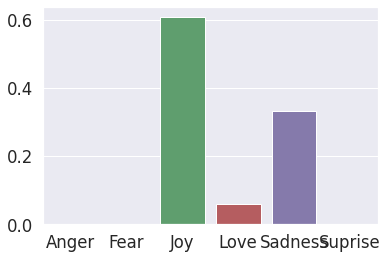

In [ ]:
jairo = X_test_df.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
sns.barplot(y=jairo,x=emotions)

##Falsos Positive

In [ ]:
Ytrue0 = Y_test.detach().numpy() == 0
Ypred1 = Y_pred.detach().numpy().round() == 1

In [ ]:
X_test_df[Ytrue0.reshape(-1) & Ypred1.reshape(-1)]  #Onde era falso e foi previsto verdadeiro  (FALSO POSITIVE)

,user,emotions_avg_dist
95,mioneswiftt,"[[0.2513755, 0.26347438, 0.14882807, 0.0063528474, 0.27080894, 0.05916044]]"
52,9256cuIt,"[[4.152537e-11, 9.5670256e-11, 0.33111197, 0.0022218332, 0.6666662, 1.1266529e-11]]"
31,puppynee,"[[0.457385, 0.042210568, 5.7946306e-07, 3.6330016e-07, 0.5000002, 0.00040323046]]"
249,hurtstolivliv,"[[0.03247349, 0.36408243, 0.3018464, 0.031710457, 0.19805217, 0.0718351]]"
163,soseguirai,"[[0.25707453, 0.16161557, 0.47203654, 0.0012113766, 0.05069887, 0.057363104]]"
234,weixiLL,"[[0.23184773, 0.19995627, 0.54628944, 0.018764671, 0.00045537873, 0.002686498]]"
18,puntztantz,"[[0.23931453, 0.20108552, 0.1996382, 0.021557758, 0.20030782, 0.13809618]]"
237,panteraalada,"[[0.0013483523, 3.2201086e-08, 0.39859244, 0.19717394, 0.40000013, 0.002885152]]"
201,wtfnatan,"[[0.4194082, 0.18837465, 0.062727176, 0.00050113647, 0.32696974, 0.0020190892]]"
186,EuricoAlves15,"[[0.31053257, 0.06590121, 0.18918854, 0.00027877084, 0.3927751, 0.04132382]]"


Primeiro exemplo

In [ ]:
usuario_teste = 'litarib'
dataset.loc[usuario_teste][['texto', 'depressao','previsoes']]

,texto,depressao,previsoes
usuario,,,
litarib,isso que é foda 😂 https://t.co/CSPMWcHi3A,0,"[0.0004836629, 8.9673773e-07, 0.89740914, 0.09986274, 8.33803e-07, 0.0022427856]"
litarib,que ódio que meu açaí veio errado uma hr esperando agr to chorando horrores pq já paguei um absurdo,0,"[0.20008317, 7.810232e-16, 0.79991686, 3.4410467e-21, 6.0032936e-16, 1.7341485e-18]"
litarib,eu nunca vou ser ela...,0,"[0.0008390594, 0.0012788462, 0.011536738, 6.30889e-06, 0.9863085, 3.0554053e-05]"


In [ ]:
dataset.loc[usuario_teste]['previsoes'].apply(lambda x: sdoom[np.argmax(np.array(x))])

usuario
litarib    Joy    
litarib    Joy    
litarib    Sadness
Name: previsoes, dtype: object

In [ ]:
plt.figure(figsize=(10, 6))
jairo = X_test_df.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
plt.bar(emotions, jairo, color=['lightcoral', 'khaki', 'bisque', 'lightsteelblue', 'lightgreen', 'thistle'])
plt.show()

In [ ]:
jairo = X_test_df.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
sns.barplot(y=jairo,x=emotions)

##True Positive

In [ ]:
Ytrue1 = Y_test.detach().numpy() == 1
Ypred1 = Y_pred.detach().numpy().round() == 1

In [ ]:
X_test_df[Ytrue1.reshape(-1) & Ypred1.reshape(-1)]  #Onde era verdadeiro e foi previsto verdadeiro  (True positive)

In [ ]:
usuario_teste = 'ggukpersona'

In [ ]:
dataset.loc[usuario_teste][['texto', 'depressao','previsoes']]

In [ ]:
dataset.loc[usuario_teste]['previsoes'].apply(lambda x: sdoom[np.argmax(np.array(x))])

In [ ]:
plt.figure(figsize=(10, 6))
jairo = X_test_df.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
plt.bar(emotions, jairo, color=['lightcoral', 'khaki', 'bisque', 'lightsteelblue', 'lightgreen', 'thistle'])
plt.show()

In [ ]:
jairo = X_test_df.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
sns.barplot(y=jairo,x=emotions)

Segundo exemplo

In [ ]:
usuario_teste = 'barbaraton'

In [ ]:
dataset.loc[usuario_teste][['texto', 'depressao','previsoes']]

In [ ]:
dataset.loc[usuario_teste]['previsoes'].apply(lambda x: sdoom[np.argmax(np.array(x))])

In [ ]:
plt.figure(figsize=(10, 6))
jairo = X_test_df.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
plt.bar(emotions, jairo, color=['lightcoral', 'khaki', 'bisque', 'lightsteelblue', 'lightgreen', 'thistle'])
plt.show()

In [ ]:
jairo = X_test_df.set_index('user').loc[usuario_teste][0]
jairo = jairo.reshape(-1)
sns.barplot(y=jairo,x=emotions)